In [1]:
from __future__ import print_function, division, absolute_import
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from BalancedDannAudioDataGenerator import BalancedAudioDataGenerator, AudioDataGenerator
import os,time
from scipy.io import loadmat
import numpy as np
np.random.seed(1)
import pandas as pd
import tables,h5py
from datetime import datetime
import argparse
from keras.utils import plot_model
# from Heartnet import heartnet,getAttentionModel
from collections import Counter
# from torchviz import make_dot
def to_numpy(x):
    return x.cpu().detach().numpy()
def plotf(x):
    plt.plot(to_numpy(x))

Using TensorFlow backend.


In [2]:
# from utils import log_macc, results_log
from dataLoader import reshape_folds
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
# import seaborn as sns
# import Evaluator
import dataLoader
# from custom_layers import Attention
from sklearn.model_selection import train_test_split

In [4]:
class wow():
    def __init__(self):
        self.dann = False
        self.self = False
        self.reduce = None
        self.shuffle = 1
        self.mfcc = False
args = wow()

In [ ]:
test_domains = 'a'
train_domains = 'cdebf'
source_domain = train_domains
target_domain = test_domains

test_split = 0
fold_dir = '../data/all_folds_wav_name/'

if(args.self):
    print("Self training activated")
    x_train, y_train, y_domain, train_parts, x_val, y_val, val_domain, val_parts,val_wav_files = dataLoader.getData(fold_dir,'',test_domains,0.9,shuffle=args.shuffle)
    print(x_train.shape, x_val.shape)
else:
    x_train, y_train, y_domain, train_parts,x_val, y_val, val_domain, val_parts, val_wav_files = dataLoader.getData(fold_dir,train_domains,test_domains,test_split,shuffle = args.shuffle)

if(args.reduce):
    print("Reduction ", args.reduce)
    x_train,_,y_train,_,y_domain,_ = train_test_split(x_train.transpose(),y_train,y_domain,stratify=y_train,test_size = args.reduce)
    x_train = x_train.transpose()

    #x_val,_,y_val,_,val_domain,_ = train_test_split(x_val.transpose(),y_val,val_domain,stratify=y_val,test_size = args.reduce)
    #x_val = x_val.transpose()

val_files = val_domain
#Create meta labels and domain labels

if(test_split>0):
    source_domain = "".join(set(source_domain).union(set(target_domain)))
    #domains = domains + test_domains

if(args.self):
    print("self training")
    source_domain = test_domains

domains = set(source_domain + target_domain)
#num_class_domain = len(set(train_domains + test_domains))
num_class_domain = len(domains)
num_class = 2

domainClass_source = [(cls,dfc) for cls in range(2) for dfc in source_domain]
domainClass_target = [(cls,dfc) for cls in range(2) for dfc in target_domain]

# Load old fold0_noFIR.mat

In [3]:
import h5py
path = '../data/fold0_noFIR.mat'
data = h5py.File(path, 'r')

In [4]:
list(data.keys())

['trainX',
 'trainY',
 'train_files',
 'train_parts',
 'valX',
 'valY',
 'val_files',
 'val_parts']

In [31]:
x_train = data['trainX'][:].astype('float32')
x_train = np.expand_dims(x_train.transpose(),1)

In [32]:
x_val = data['valX'][:].astype('float32')
x_val = np.expand_dims(x_val.transpose(),1)

In [33]:
y_train = data['trainY'][:].astype('int32')
y_train = y_train.transpose()
y_train = y_train[:,0]
y_train[y_train<0] = 0

In [34]:
y_val = data['valY'][:].astype('int32')
y_val = y_val.transpose()
y_val = y_val[:,0]
y_val[y_val<0] = 0

In [15]:
val_parts = data['val_parts'][:].astype('int32').squeeze(0)
val_files = data['val_files'][:].astype('int32').squeeze(0)
train_files = data['train_files'][:].astype('int32').squeeze(0)

In [36]:
domains = list(Counter(train_files).keys())
domainClass = [(cls,dfc) for cls in range(2) for dfc in domains]
meta_labels = [domainClass.index((cl,df)) for (cl,df) in zip((y_train),train_files)]

# Load new folds

In [39]:
alldata = pd.read_hdf('../data/data.h5', 'df')
fold_number = 3
f = open(("../data/text/train"+str(fold_number)+".txt"), "r")
lines = list(f)
f.close()
lines1 = [(x[:-1]+".wav") for x in lines]
f = open("../data/text/validation"+str(fold_number)+".txt", "r")
lines = list(f)
f.close()
vallines = [(x[:-1]+".wav") for x in lines]
train0 = alldata.loc[alldata['wav_name'].isin(lines1)]
val0 = alldata.loc[alldata['wav_name'].isin(vallines)]
print(sum(alldata['train_parts']),sum(train0['train_parts']),sum(val0['train_parts']))

x_train = np.concatenate((train0['x_train']).tolist())
x_train = np.expand_dims(x_train,1)
y_train = np.concatenate((train0['y_train']).tolist())
x_val = np.concatenate((val0['x_train']).tolist())
x_val = np.expand_dims(x_val,1)
y_val = np.concatenate((val0['y_train']).tolist())
train_parts = np.array(train0['train_parts'])
val_parts = np.array(val0['train_parts'])
train_files = np.concatenate((train0['train_files']).tolist())
del alldata,train0,val0

81495 72524 8971


In [40]:
domains = list(Counter(train_files).keys())
domainClass = [(cls,dfc) for cls in range(2) for dfc in domains]
meta_labels = [domainClass.index((cl,df)) for (cl,df) in zip((y_train),train_files)]

In [23]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape,train_files.shape

((72754, 1, 2500), (72754,), (8741, 1, 2500), (8741,), (72754,))

# mfcc extraction

In [ ]:
## Convert to MFCC
import python_speech_features as psf
from matplotlib import cm
if(args.mfcc):
    train_mfcc = np.array([(psf.base.mfcc(x,samplerate=1000,winlen=0.05,winstep=0.01)) for x in x_train.transpose()])
    val_mfcc = np.array([(psf.base.mfcc(x,samplerate=1000,winlen=0.05,winstep=0.01)) for x in x_val.transpose()])
    
    train_mfcc = (train_mfcc-np.mean(train_mfcc))/np.std(train_mfcc)
    val_mfcc = (val_mfcc-np.mean(val_mfcc))/np.std(val_mfcc)
    #train_mfcc = train_mfcc/np.max(np.abs(train_mfcc))
    #val_mfcc = val_mfcc/np.max(np.abs(val_mfcc))
    
    del x_train, x_val
    x_train = train_mfcc.copy()
    x_val = val_mfcc.copy()
    print(x_train.shape, x_val.shape)

In [5]:
meta_labels_source = [domainClass_source.index((cl,df)) for (cl,df) in zip(y_train,y_domain)]
meta_labels_target = None
if(args.dann):
    meta_labels_target = [domainClass_target.index((cl,df)) for (cl,df) in zip((y_val),(val_domain))]
    

domains = "".join(set(source_domain).union(set(target_domain)))

y_domain_source = np.array([list(domains).index(lab) for lab in y_domain])

y_domain_target = np.array([list(domains).index(lab) for lab in val_domain])

################### Reshaping ############

if(args.mfcc):
    [], [y_train,y_domain,y_val] = reshape_folds([],[y_train,y_domain_source,y_val])
else:
    [x_train,x_val], [y_train,y_domain,y_val] = reshape_folds([x_train,x_val],[y_train,y_domain_source,y_val])
y_train = to_categorical(y_train, num_classes=num_class)

print("Y domain ", Counter([x[0] for x in y_domain]))
print("Val domain ", Counter(val_domain))
print("Source Meta labels ", Counter(meta_labels_source))
print("Target Meta labels ", Counter(meta_labels_target))
y_domain_source = to_categorical(y_domain_source,num_classes=num_class_domain)

y_val = to_categorical(y_val, num_classes=num_class)
y_domain_target = to_categorical(y_domain_target,num_classes=num_class_domain)


val_domain = y_domain_target
print("Train files ", y_train.shape, "  Domain ", y_domain.shape)
print("Test files ", y_val.shape, "  Domain ", val_domain.shape)

### Batch Size limmiter 
batch_size = 1000
if(batch_size > max(y_train.shape)):
    print("Batch size if given greater than train files size. limiting batch size")
    batch_size = max(y_train.shape)

reshaped x  (67328, 2500, 1)
reshaped x  (14167, 2500, 1)
reshaped Y  (67328, 1)
reshaped Y  (67328, 1)
reshaped Y  (14167, 1)
Y domain  Counter({3: 57642, 2: 4119, 1: 2985, 5: 1781, 0: 801})
Val domain  Counter({'a': 14167})
Source Meta labels  Counter({2: 54790, 4: 3012, 7: 2852, 3: 2396, 5: 1425, 9: 1107, 8: 589, 6: 493, 0: 356, 1: 308})
Target Meta labels  Counter()
Train files  (67328, 2)   Domain  (67328, 1)
Test files  (14167, 2)   Domain  (14167, 6)


In [2]:
x_train.shape,x_val.shape, y_train.shape, y_val.shape, y_domain.shape,val_domain.shape,Counter(meta_labels_source),Counter(meta_labels_target)

NameError: name 'x_train' is not defined

In [8]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [6]:
y_train = np.argmax(y_train,1)

In [7]:
y_val = np.argmax(y_val,1)

In [26]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((79810, 1, 2500), (79810,), (6710, 1, 2500), (6710,))

In [9]:
######## change 2500 axis for pytorch 
x_train = x_train.transpose((0,2,1))
x_val = x_val.transpose((0,2,1))

In [1]:
x_train.shape,y_train.shape

NameError: name 'x_train' is not defined

In [18]:
x_train = x_train[:2100,:,:]
y_train = y_train[:20000]

In [41]:
batch_size = 100
datagen_source = BalancedAudioDataGenerator(shift=.1,data_format = 'channels_first')
flow_source = datagen_source.flow(x_train, y_train,
                meta_label=meta_labels,
                batch_size=batch_size, shuffle=True,
                seed=1)
# datagen_source_balanced = AudioDataGenerator(shift=.1,data_format = 'channels_first')
# flow_source = datagen_source_balanced.flow(x_train, y_train,
#                 batch_size=batch_size, shuffle=True,
#                 seed=1)
# datagen_val = BalancedAudioDataGenerator(shift=.1,data_format = 'channels_first')
# flow_val = datagen_val.flow(x_val, y_val,
#                 meta_label=y_val,
#                 batch_size=batch_size, shuffle=True,
#                 seed=1)
try:
    flow_source.steps_per_epoch = len(flow_source)
except:
    pass

[ 4008  2287   356   258 50868  2724  7249   474  1168   369  2152   611]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
Chunk size selected as 8


In [28]:
x,y = flow_source.next()
x,y = torch.from_numpy(x),torch.from_numpy(y)
x = x.type(torch.FloatTensor).cuda()
holdx = x
print(x.shape)
# x = mfcc_gen(x)
x.shape

torch.Size([96, 1, 2500])


torch.Size([96, 1, 2500])

In [34]:
model(x).shape

torch.Size([12, 2])

In [57]:

hold = x
x = x.transpose(2,1)
x = x.unsqueeze(1)
print(x.shape)

torch.Size([24, 1, 64, 1, 240])


In [8]:
import torch.optim as optim
import torch
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np

In [9]:
import HeartCepTorch,importlib
HeartCepTorch = importlib.reload(HeartCepTorch)
from HeartCepTorch import MFCC_Gen,Network,MFCC_Gen_coeff

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torchsummary import summary
from torch.nn.parameter import Parameter

In [17]:
from torch.nn.parameter import Parameter
from HeartCepTorch import Conv_Gammatone_coeff
class Branch(nn.Module):
    def __init__(self,c_in, c_out, kernel_size=5,stride=1,dropout = 0.5):
        super(Branch, self).__init__()
        self.conv1 = nn.Conv1d(c_in, c_out*2, kernel_size=kernel_size,stride=stride)
        self.bn1 = nn.BatchNorm1d(c_out*2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(c_out*2, c_out, kernel_size=kernel_size,stride=stride)
        self.bn2 = nn.BatchNorm1d(c_out)
        self.pool = nn.MaxPool1d(2)
    def forward(self, x):
        x = self.drop(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(x)
        x = self.drop(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(x)
        return x
class Net(nn.Module):
    def __init__(self,filters=64,kernel_size=81,fs=1000):
        super(Net,self).__init__()
        wow = Conv_Gammatone_coeff(1,filters,kernel_size,fs)
        self.filterbank = nn.ModuleList()
        for i in range(filters):
            conv = nn.Conv1d(1,1,kernel_size=kernel_size)
            conv.weight = Parameter(wow.weight[i:i+1])
            self.filterbank.append(conv)
        self.branches = nn.ModuleList()
        for i in range(filters):
            branch = Branch(1,4)
            self.branches.append(branch)
        self.dense = nn.Linear(4*602*filters,20)
        self.cls = nn.Linear(20,2)
        self.relu = nn.ReLU()
        self.soft = nn.Softmax()
    def forward(self,x):
        x = [c(x) for c in self.filterbank]
        x = [c(xx) for (xx,c) in zip(x,self.branches)]
        x = torch.cat(x,dim=1)
        x = x.view(x.size(0),-1)
        x = self.relu(self.dense(x))
        x = self.soft(self.cls(x))
        return x
model = Net()

In [15]:
model = Network(2,0,in_feature=7680,res_block=3)
mfcc_gen = MFCC_Gen_coeff(fs=1000,filters=16,momentum=0.1)

Using only  3  resudual blocks out of 4


In [19]:
path = '/media/mhealthra2/Data/heart_sound/Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR dbt 64 HNET_2020-05-17 17.56.06.569274/weights/'
weights = os.listdir(path)
wow = dict(torch.load(path+weights[53]))
gamma_weight = torch.cat([wow['filterbank.{}.weight'.format(i)] for i in range(64)])  

In [68]:
from torch.nn.parameter import Parameter
mfcc_gen.gamma.weight = Parameter(gamma_weight)

NameError: name 'gamma_weight' is not defined

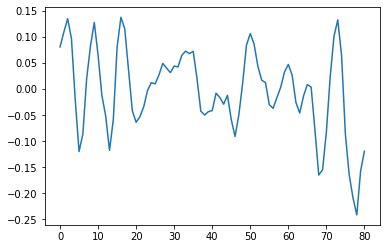

In [25]:
plt.plot(to_numpy(mfcc_gen.gamma.weight[35]).squeeze())

In [49]:
summary(mfcc_gen.cuda(),(1,2500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 2420]           1,312
       BatchNorm1d-2             [-1, 16, 2420]              32
            Conv1d-3              [-1, 16, 240]           6,400
       BatchNorm1d-4              [-1, 16, 240]              32
Total params: 7,776
Trainable params: 7,776
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.65
Params size (MB): 0.03
Estimated Total Size (MB): 0.69
----------------------------------------------------------------


In [52]:
summary(model.cuda(),(1,240,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 244, 17]             112
       BatchNorm2d-2          [-1, 16, 244, 17]              32
            Conv2d-3          [-1, 32, 242, 15]           4,640
       BatchNorm2d-4          [-1, 32, 242, 15]              64
         Dropout2d-5          [-1, 32, 242, 15]               0
            Conv2d-6          [-1, 32, 244, 17]           9,248
       BatchNorm2d-7          [-1, 32, 244, 17]              64
         Dropout2d-8          [-1, 32, 244, 17]               0
            Conv2d-9           [-1, 64, 122, 8]          18,496
      BatchNorm2d-10           [-1, 64, 122, 8]             128
        Dropout2d-11           [-1, 64, 122, 8]               0
           Conv2d-12            [-1, 64, 61, 4]          36,928
      BatchNorm2d-13            [-1, 64, 61, 4]             128
        Dropout2d-14            [-1, 64

In [37]:
summary(mfcc_gen.cuda(),(1,2500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    Conv_Gammatone-1             [-1, 64, 2420]             192
       BatchNorm1d-2             [-1, 64, 2420]             192
            Conv1d-3              [-1, 64, 240]         102,400
       BatchNorm2d-4           [-1, 1, 64, 240]               3
Total params: 102,787
Trainable params: 195
Non-trainable params: 102,592
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.60
Params size (MB): 0.39
Estimated Total Size (MB): 3.00
----------------------------------------------------------------


In [11]:
class WHOLE_MODEL(nn.Module):
    def __init__(self,kernel_size = 81,filters = 26,fs=1000,winlen=0.025,winstep=0.01,dimension=1):
        super(WHOLE_MODEL,self).__init__()
        self.mfcc = MFCC_Gen(fs=1000,filters=filters,momentum=0.99)
        self.classifier = Network(2,0,in_feature=7680,res_block=3)
#         for x in self.mfcc.gamma.named_parameters():
#             x[1].requires_grad = False
    def forward(self,x):
        x = self.mfcc(x)
#         x = x.unsqueeze(1)
#         x = x.transpose(3,2)
        x = self.classifier(x)
        return x#,mfcc

In [35]:
model = WHOLE_MODEL(filters=16)
model.mfcc.mfcc.weight.requires_grad = False
model.cuda()
model.mfcc.mfcc.weight.requires_grad = False

Using only  3  resudual blocks out of 4


In [68]:
path = "/home/jupyter/Istiaq_Ansari/Heartnet_Results/logs/gammatone_torch_layer/JUST TESTING _2020-08-24 14.40.14.375265  Batch 100*10, filter 16/weights/weights.0069-acc_0.7999-macc_0.8796.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [82]:
# for x in model.classifier.named_parameters():
#     x[1].requires_grad = True
# for x in model.mfcc.named_parameters():
#     x[1].requires_grad = True

In [10]:
halfprecision = True

In [18]:
if(halfprecision):
    model.half()
    for layer in model.modules():
        if isinstance(layer,nn.BatchNorm2d):
            layer.float()

In [17]:
summary(model.float(),(1,2500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    Conv_Gammatone-1             [-1, 16, 2420]               0
            Conv1d-2              [-1, 16, 240]           6,400
          MFCC_Gen-3           [-1, 1, 240, 16]               0
            Conv2d-4          [-1, 16, 244, 17]             112
       BatchNorm2d-5          [-1, 16, 244, 17]              32
            Conv2d-6          [-1, 32, 242, 15]           4,640
       BatchNorm2d-7          [-1, 32, 242, 15]              64
         Dropout2d-8          [-1, 32, 242, 15]               0
            Conv2d-9          [-1, 32, 244, 17]           9,248
      BatchNorm2d-10          [-1, 32, 244, 17]              64
        Dropout2d-11          [-1, 32, 244, 17]               0
           Conv2d-12           [-1, 64, 122, 8]          18,496
      BatchNorm2d-13           [-1, 64, 122, 8]             128
        Dropout2d-14           [-1, 64,

In [37]:
optimizer = optim.SGD([ {'params': model.mfcc.parameters(), 'lr':0.1}, {'params': model.classifier.parameters()} ], lr=0.005)

In [38]:
# optimizer = optim.SGD(model.parameters(), lr= .01)
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()
# class_criterion = nn.BCELoss()
start_epoch = 0
lr_schedule = optim.lr_scheduler.ExponentialLR(optimizer,1)
# wow= []
# for i in range(400):
#     optimizer.step()
#     wow.append(optimizer.param_groups[0]['lr'])
#     sh.step()
# plt.plot(wow)
# print(wow[-1])

In [15]:
from sklearn.metrics import confusion_matrix
eps = 0.0000001
def log_macc(y_pred, y_val,val_parts):
    y_pred = y_pred.cpu().detach().numpy()
#     y_pred_domain = y_pred_domain.cpu().detach().numpy()
    y_val = y_val.cpu().detach().numpy()
    true = []
    pred = []
    files = []
    start_idx = 0

#     y_pred = np.argmax(y_pred, axis=-1)
#     y_val = np.transpose(np.argmax(y_val, axis=-1))

    for j,s in enumerate(val_parts):

        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
        
        temp_ = y_val[start_idx:start_idx + int(s)]
        temp = y_pred[start_idx:start_idx + int(s)]

        if (sum(temp == 0) > sum(temp == 1)):
            pred.append(0)
        else:
            pred.append(1)

        if (sum(temp_ == 0) > sum(temp_ == 1)):
            true.append(0)
        else:
            true.append(1)

#         if val_files is not None:
#             files.append(val_files[start_idx])

        start_idx = start_idx + int(s)
    TN, FP, FN, TP = confusion_matrix(true, pred, labels=[0,1]).ravel()
    # TN = float(TN)
    # TP = float(TP)
    # FP = float(FP)
    # FN = float(FN)
    sensitivity = TP / (TP + FN + eps)
    specificity = TN / (TN + FP + eps)
    precision = TP / (TP + FP + eps)
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
    Macc = (sensitivity + specificity) / 2
    
    print("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)
    print("Sensitivity:","%.2f"%sensitivity,"Specificity:","%.2f"%specificity,"Precision:","%.2f"%precision,end=' ')
    print("F1:", "%.2f"%F1,"MACC", "%.2f"%Macc)
    return Macc,sensitivity,specificity,precision,F1
def trainLog(y_true,y_pred):
    eps = 0.0000001
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    sensitivity = TP / (TP + FN + eps)
    specificity = TN / (TN + FP + eps)
    precision = TP / (TP + FP + eps)
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
    Macc = (sensitivity + specificity) / 2
    print("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)
    print("Sensitivity:","%.2f"%sensitivity,"Specificity:","%.2f"%specificity,"Precision:","%.2f"%precision,end=' ')
    print("F1:", "%.2f"%F1,"MACC", "%.2f"%Macc)
    

In [42]:
import importlib,os
from datetime import datetime
import CSVLogger
CSVLogger = importlib.reload(CSVLogger)
from CSVLogger import CSVLogger
fold = "fold3_noFIR JUST_TESTING classifier 0.005 mfcc 0.1 HALF PRECISION" 
path = "../../Heartnet_Results/logs/gammatone_torch_layer/"
fold = fold+'_'+str(datetime.now()).replace(':','.')
path = path + fold
if not os.path.isdir(path):
    os.mkdir(path)
    os.mkdir(os.path.join(path,'weights'))
logger = CSVLogger(path+'/'+'training.csv')
checkpoint_name = os.path.join(path,'weights') + "/" + 'weights.{epoch:04d}-acc_{val_acc:.4f}-macc_{macc:.4f}.pt'

# Whole

In [ ]:
model.cuda()
epochs = 1000

logger
logger.on_train_begin()
optimizer.zero_grad()
print("steps ", flow_source.steps_per_epoch)
for e in range(start_epoch,epochs):
    print("EPOCH   ",e+1)
    print("learning rate ",optimizer.param_groups[0]['lr'])
    model.train()
    epoch_loss = 0
    epoch_loss_list = []
    acc = 0
    N = 0
    optimizer.zero_grad()
    for i in range(flow_source.steps_per_epoch+1):


        

        x,y = flow_source.next()
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
#         if(halfprecision):
        
        x,y = Variable(x),Variable(y)
        y = y.long().cuda()
        cls = model(x)
#         print("passed ",i+1)
        # class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
        class_loss = class_criterion(cls,y)
        loss = class_loss
        epoch_loss = epoch_loss + loss
        epoch_loss_list.append(loss)
        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)

        loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         print("hocche ", i)
        if(i%10==0 or i==flow_source.steps_per_epoch):
#             print("     backward at ",i+1)
            
            optimizer.step()
            optimizer.zero_grad()
        

#             print("         backward complete ",i+1)

    print("Training loss", "%.2f"%(epoch_loss.item()/flow_source.steps_per_epoch),end=' ')
    print("Training loss list", "%.2f"%(torch.mean(torch.tensor(epoch_loss_list)).item()),end=' ')
    print("Training Acc ", "%.2f"%(acc.item()/N))
    logger.logs['train_loss'] = (epoch_loss.item()/flow_source.steps_per_epoch)
    logger.logs['train_acc'] = (acc.item()/N)
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    N = 0
    y_pred = None
    y_true = None
    
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            if(s==0):
                continue
            x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
            start_idx = start_idx+s
            x,y = torch.from_numpy(x),torch.from_numpy(y)
            x = x.type(torch.FloatTensor).cuda()
            x,y = Variable(x),Variable(y)
            y = y.long().cuda()
            cls= model(x)
            val_class_loss = class_criterion(cls,y)
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
#     lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e) 
    flow_source.reset()
logger.on_train_end()

steps  6358
EPOCH    1
learning rate  0.1
Training loss 0.65 Training loss list 0.65 Training Acc  0.61
TN: 113 FP: 40 FN: 77 TP: 72
Sensitivity: 0.48 Specificity: 0.74 Precision: 0.64 F1: 0.55 MACC 0.61
Validation loss 0.67 Validation Acc  0.56
EPOCH    2
learning rate  0.1
Training loss 0.59 Training loss list 0.59 Training Acc  0.71
TN: 111 FP: 42 FN: 63 TP: 86
Sensitivity: 0.58 Specificity: 0.73 Precision: 0.67 F1: 0.62 MACC 0.65
Validation loss 0.64 Validation Acc  0.62
EPOCH    3
learning rate  0.1


In [42]:
type(x.half())

torch.Tensor

In [28]:
model.cuda()
x,y = flow_source.next()
x,y = torch.from_numpy(x),torch.from_numpy(y)
x = x.type(torch.FloatTensor).cuda()
x,y = Variable(x),Variable(y)
y = y.long().cuda()   

In [29]:
torch.sum(torch.isnan(x)==True),torch.sum(torch.isnan(y)==True)

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

In [30]:
print('max X ',torch.max(x),'min X ',torch.min(x))
cls = model(x)
#         print("passed ",i+1)
# class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
class_loss = class_criterion(cls,y)
class_loss,cls.transpose(1,0)

max X  tensor(0.4413, device='cuda:0') min X  tensor(-0.4603, device='cuda:0')


(tensor(0.5087, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[1.4146e-03, 3.3798e-02, 1.0000e+00, 9.9976e-01, 1.0000e+00, 5.4486e-01,
          7.8134e-03, 1.7505e-15, 8.2231e-11, 1.9688e-02, 2.3381e-06, 7.9903e-02],
         [9.9859e-01, 9.6620e-01, 2.0726e-22, 2.3660e-04, 2.8160e-09, 4.5514e-01,
          9.9219e-01, 1.0000e+00, 1.0000e+00, 9.8031e-01, 1.0000e+00, 9.2010e-01]],
        device='cuda:0', grad_fn=<TransposeBackward0>))

In [31]:
class_loss.backward()

In [39]:
model.classifier.classifier.fc2.weight.grad

tensor([[ 1.9067e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  9.5673e-03,  0.0000e+00,  0.0000e+00,
         -8.9026e-02,  0.0000e+00,  0.0000e+00,  8.8881e-03,  0.0000e+00,
          0.0000e+00, -1.9325e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.3443e-03,  8.1384e-02,  0.0000e+00,  0.0000e+00, -4.4249e-05,
          7.5216e-04, -1.2454e-04,  0.0000e+00,  1.6521e-04,  2.9267e-03,
          0.0000e+00,  5.5258e-03,  0.0000e+00,  8.7702e-13,  3.4549e-02,
          0.0000e+00,  0.0000e+00, -2.3838e-02,  0.0000e+00, -2.0295e-01,
          3.9497e-02,  3.0209e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.7315e-02,  0.0000e+00,  0.0000e+00, -1.5938e-02,
          0.0000e+00,  0.0000e+00, -2.2819e-01, -1.4189e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.

In [38]:
model.mfcc.gamma.fc.grad

tensor([[ 0.0000e+00],
        [ 1.6151e-04],
        [-7.3421e-05],
        [-9.5191e-03],
        [ 2.2808e-03],
        [ 2.0580e-03],
        [-5.3329e-06],
        [ 2.2342e-04],
        [ 1.2264e-02],
        [ 1.8686e-03],
        [ 1.2190e-04],
        [ 2.9563e-04],
        [-1.0619e-04],
        [-7.5568e-04],
        [ 3.1244e-04],
        [-4.0365e-05],
        [-8.8188e-04],
        [-2.9208e-05],
        [ 5.7191e-06],
        [-2.0685e-05],
        [-6.6930e-05],
        [ 7.1591e-04],
        [ 3.6045e-06],
        [ 1.6076e-05],
        [ 6.6771e-08],
        [ 2.7210e-05],
        [-6.0837e-05],
        [ 4.2258e-04],
        [ 8.0331e-07],
        [-2.3526e-06],
        [ 6.4785e-06],
        [ 1.0810e-06],
        [-2.0534e-06],
        [-1.8526e-05],
        [-1.4764e-06],
        [ 9.8876e-08],
        [-2.9621e-06],
        [-4.1990e-07],
        [ 2.4038e-07],
        [ 1.2896e-06],
        [ 3.9566e-07],
        [ 3.8345e-06],
        [-4.1530e-07],
        [-1

In [165]:
model.mfcc.mfcc.weight.requires_grad = False

In [166]:
optimizer.step()
optimizer.zero_grad()

In [33]:
model

WHOLE_MODEL(
  (mfcc): MFCC_Gen_coeff(
    (gamma): Conv1d(1, 64, kernel_size=(81,), stride=(1,))
    (gammanorm): BatchNorm1d(64, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
    (mfcc): Conv1d(64, 64, kernel_size=(25,), stride=(10,), bias=False)
    (normmfcc): BatchNorm1d(64, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
    (normmfcc2D): BatchNorm2d(1, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
  )
  (classifier): Network(
    (extractor): Extractor(
      (conv0): Conv2d(1, 16, kernel_size=(3, 2), stride=(1, 1), padding=(3, 1))
      (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (bn11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True,

# gradient accu

In [ ]:

###   MFCC

model.cuda()
mfcc_gen.cuda()
mfcc_gen.eval()
epochs = 1500
# torch.save(model,os.path.join(path,'model.pt'))
logger.on_train_begin()
print("steps ", flow_source.steps_per_epoch)

# with open(path+fold+'/model1.json', 'w') as outfile:
#     outfile.write(str(mod))
for e in range(epochs):
    print("EPOCH   ",e+1)
    print("learning rate ",optimizer.param_groups[0]['lr'])
    model.train()
    epoch_loss = 0
    acc = 0
    y_pred = None
    y_true = None
    N = 0
    
    optimizer.zero_grad()
    for i in range(flow_source.steps_per_epoch+1):
        
        
        x,y = flow_source.next()
        if(str(class_criterion) in ['MSELoss()','BCELoss()']):
            y = to_categorical(y,2)
            y = y.astype(np.float32)
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
        holdx = x
        x = mfcc_gen(x)
#         if(len(x)>1):
#             x = x[0]
        hold = x
        x = x.transpose(2,1)
        x = x.unsqueeze(1)
        # print(x.shape)
        x,y = Variable(x),Variable(y)
        
#         y = y.cuda()
        y = y.long().cuda()        
        cls = model(x)
        # class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
        loss = class_criterion(cls,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss = epoch_loss + loss
#         if(i%1==0 or i==flow_source.steps_per_epoch):            
#             optimizer.step()
#             optimizer.zero_grad()
        
        
#         if(str(class_criterion)in ['MSELoss()','BCELoss()']):
#             y = torch.argmax(y,axis=1)
        if(y_pred is None):
            y_pred = torch.argmax(cls,axis=1)
            y_true = y
        else:
            y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
            y_true = torch.cat((y_true,y))
    
        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)
    epoch_loss_print = (epoch_loss.item()) if (type(epoch_loss)==torch.Tensor) else epoch_loss
    acc_print = (acc.item()) if (type(acc)==torch.Tensor) else acc
    print("Training loss", "%.2f"%(epoch_loss_print/flow_source.steps_per_epoch),end=' ')
    print("Training Acc ", "%.2f"%(acc_print/N),end=' ')
    trainLog(y_true,y_pred)
    logger.logs['train_loss'] = (epoch_loss_print/flow_source.steps_per_epoch)
    logger.logs['train_acc'] = (acc_print/N)
    
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    N = 0
    y_pred = None
    y_true = None
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            if(s==0):
                continue
            x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
            start_idx = start_idx+s
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = to_categorical(y,2)
                y = y.astype(np.float32)
            
            x,y = torch.from_numpy(x),torch.from_numpy(y)
            x = x.type(torch.FloatTensor).cuda()
            holdvalx = x
            x = mfcc_gen(x)
#             if(len(x)>1):
#                 x = x[0]
            holdval = x
            x = x.transpose(2,1)
            x = x.unsqueeze(1)
            x,y = Variable(x),Variable(y)
            #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            
#             y = y.cuda()
            y = y.long().cuda()
            cls= model(x)
            # val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
            val_class_loss = class_criterion(cls,y)
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = torch.argmax(y,axis=1)
            
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
    lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e)
    flow_source.reset()
logger.on_train_end()

steps  666
EPOCH    1
learning rate  0.005
Training loss 0.69 Training Acc  0.54 TN: 183690 FP: 148476 FN: 156050 TP: 176116
Sensitivity: 0.53 Specificity: 0.55 Precision: 0.54 F1: 0.54 MACC 0.54
TN: 106 FP: 40 FN: 62 TP: 76
Sensitivity: 0.55 Specificity: 0.73 Precision: 0.66 F1: 0.60 MACC 0.64
Validation loss 0.64 Validation Acc  0.62
EPOCH    2
learning rate  0.005


In [20]:
x,y = flow_source.next()
x,y = torch.from_numpy(x),torch.from_numpy(y)
x = x.type(torch.FloatTensor).cuda()
x,y = Variable(x),Variable(y)
holdx = x
mfcc_gen.cuda()
mfcc_gen.eval()
x = mfcc_gen(x)
hold = x
x = x.transpose(2,1)
x = x.unsqueeze(1)
 print(x.shape)
x,y = Variable(x),Variable(y)
y = y.long().cuda() 
model.cuda()
cls = model(x)

In [23]:
x,y = flow_source.next()
x.shape

(0, 1, 2500)

In [21]:
plt.plot(to_numpy(holdx[0,0,:]))

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
plt.figure(figsize=(20,20))
from matplotlib import cm
plt.imshow((to_numpy(hold[0,:,:])), interpolation='nearest', origin='lower')
# plt.plot(to_numpy(x[0,0,:,:]).transpose())

In [83]:
loss = class_criterion(cls,y)
print(loss)
optimizer.zero_grad()

tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)


In [85]:
loss.backward()

In [87]:
cls

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [176]:
holdx[5:6,0,:].shape

torch.Size([1, 2500])

In [67]:
import HeartCepTorch,importlib
HeartCepTorch = importlib.reload(HeartCepTorch)
from HeartCepTorch import MFCC_Gen,Network,MFCC_Gen_coeff

In [68]:
mfcc_gen = MFCC_Gen(fs=1000,filters=64,momentum=0.1)

In [69]:
mfcc_gen.eval()

MFCC_Gen(
  (gamma): Conv_Gammatone(1, 64, kernel_size=(81,), stride=(1,), bias=False)
  (gammanorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mfcc): Conv1d(64, 64, kernel_size=(25,), stride=(10,), bias=False)
  (normmfcc): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normmfcc2D): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activate): Tanh()
)

In [127]:
 mfcc_gen.gammanorm.weight

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', requires_grad=True)

In [129]:
 mfcc_gen.gammanorm.weight

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', requires_grad=True)

torch.Size([1, 64, 2420]) tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 64, 2420]) tensor(-0.0082, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 64, 2420]) tensor(7.7055e-07, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 64, 240]) tensor(1.8845e-06, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 64, 240]) tensor(-162256.0469, device='cuda:0', grad_fn=<SumBackward0>)


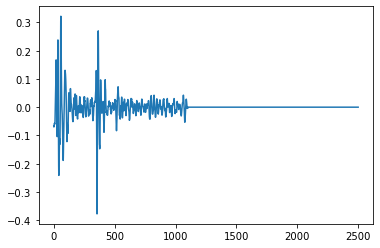

In [164]:
mfcc_gen.cuda()
mfcc_gen.train()

plt.plot(to_numpy(holdx[5:6,0,:]).transpose())
# xx = mfcc_gen(holdx[5:6,:,:])
xx = mfcc_gen.gamma(holdx[5:6,:,:])
print(xx.shape,torch.sum(xx[0,:,1500:]))

# mx = torch.max(abs(xx),axis=2)[0]
# xx = (xx/mx[:,:,None])

xx = mfcc_gen.gammanorm(xx)
print(xx.shape,torch.sum(xx[0,:,1500:]))

xx = torch.pow(torch.abs(xx),2)
print(xx.shape,torch.sum(xx[0,:,1500:]))

xx = mfcc_gen.mfcc(xx)
print(xx.shape,torch.sum(xx[0,:,150:]))

xx = torch.log(xx+0.0000000000000001)
print(xx.shape,torch.sum(xx[0,:,150:]))

# # xx = mfcc_gen.normmfcc(xx)
# print(xx.shape,torch.sum(xx[0,:,150:]))



In [159]:
mean = torch.mean(xx,axis=2)
std = torch.std(xx,axis=2)
mx = torch.max(abs(xx),axis=2)[0]
mx[:,:,None].shape,xx.shape
xx = (xx/mx[:,:,None])

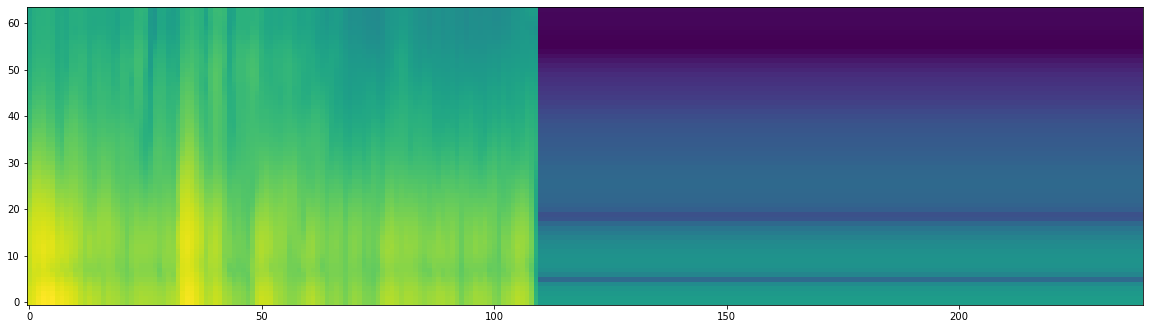

In [165]:
plt.figure(figsize=(20,20))
from matplotlib import cm
plt.imshow((to_numpy(xx[0,:,:])), interpolation='nearest', origin='lower')
# plt.imshow((to_numpy(xx[0,0,:,:]).transpose()), interpolation='nearest', origin='lower')
# plt.plot(to_numpy(x[0,0,:,:]).transpose())

In [45]:
wow = nn.Conv1d(1,16,kernel_size=81)
wow.cuda()

Conv1d(1, 16, kernel_size=(81,), stride=(1,))

In [109]:
torch.min(holdx[0,:,:]),torch.max(holdx[0,:,:])

(tensor(-0.0718, device='cuda:0'), tensor(0.0525, device='cuda:0'))

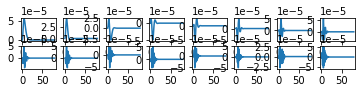

In [106]:
for i in range(16):
#     plt.figure(figsize=(40,5))
    w = mfcc_gen.gamma.weight[i,0,:]
    plt.subplot(8,8,i+1)
    plt.plot(to_numpy(w).squeeze().squeeze())

In [ ]:
### HEartnet

epochs = 1500
# torch.save(model,os.path.join(path,'model.pt'))
logger.on_train_begin()
print("steps ", flow_source.steps_per_epoch)

# with open(path+fold+'/model1.json', 'w') as outfile:
#     outfile.write(str(mod))
for e in range(epochs):
    print("EPOCH   ",e+1)
    print("learning rate ",optimizer.param_groups[0]['lr'])
    model.train()
    epoch_loss = 0
    acc = 0
    y_pred = None
    y_true = None
    N = 0
    
    optimizer.zero_grad()
    for i in range(flow_source.steps_per_epoch+1):
        
        
        x,y = flow_source.next()
        if(str(class_criterion) in ['MSELoss()','BCELoss()']):
            y = to_categorical(y,2)
            y = y.astype(np.float32)
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
        # print(x.shape)
        x,y = Variable(x),Variable(y)
        
#         y = y.cuda()
        y = y.long().cuda()        
        cls = model(x)
        # class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
        loss = class_criterion(cls,y)
        loss.backward()
        epoch_loss = epoch_loss + loss
        if(i%50==0 or i==flow_source.steps_per_epoch):            
            optimizer.step()
            optimizer.zero_grad()
        
        
#         if(str(class_criterion)in ['MSELoss()','BCELoss()']):
#             y = torch.argmax(y,axis=1)
        if(y_pred is None):
            y_pred = torch.argmax(cls,axis=1)
            y_true = y
        else:
            y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
            y_true = torch.cat((y_true,y))
    
        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)
    epoch_loss_print = (epoch_loss.item()) if (type(epoch_loss)==torch.Tensor) else epoch_loss
    acc_print = (acc.item()) if (type(acc)==torch.Tensor) else acc
    print("Training loss", "%.2f"%(epoch_loss_print/flow_source.steps_per_epoch),end=' ')
    print("Training Acc ", "%.2f"%(acc_print/N),end=' ')
    trainLog(y_true,y_pred)
    logger.logs['train_loss'] = (epoch_loss_print/flow_source.steps_per_epoch)
    logger.logs['train_acc'] = (acc_print/N)
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    N = 0
    y_pred = None
    y_true = None
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            if(s==0):
                continue
            x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
            start_idx = start_idx+s
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = to_categorical(y,2)
                y = y.astype(np.float32)
            
            x,y = torch.from_numpy(x),torch.from_numpy(y)
            x = x.type(torch.FloatTensor).cuda()
            
            x,y = Variable(x),Variable(y)
            #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            
#             y = y.cuda()
            y = y.long().cuda()
            cls= model(x)
            # val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
            val_class_loss = class_criterion(cls,y)
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = torch.argmax(y,axis=1)
            
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
    lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e)
    flow_source.reset()
logger.on_train_end()

# MFCC gen(not learning) -> Classfier(learning) two modules

In [ ]:
optimizer.param_groups[0]['lr']

In [21]:
path = '../../Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR batch1500 continued .005_2020-04-14 16.10.52.323265/weights/weights.0154-acc_0.7942-macc_0.8296.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [40]:
cls.shape, y.shape

(torch.Size([1, 2]), torch.Size([12]))

In [19]:
model.cuda()
mfcc_gen.cuda()
mfcc_gen.eval()
epochs = 400
# torch.save(model,os.path.join(path,'model.pt'))
logger.on_train_begin()
print("steps ", flow_source.steps_per_epoch)

# with open(path+fold+'/model1.json', 'w') as outfile:
#     outfile.write(str(mod))
for e in range(epochs):
    print("EPOCH   ",e+1)
    print("learning rate ",optimizer.param_groups[0]['lr'])
    model.train()
    epoch_loss = 0
    acc = 0
    y_pred = None
    y_true = None
    N = 0
    for i in range(flow_source.steps_per_epoch+1):
        optimizer.zero_grad()
        
        x,y = flow_source.next()
        if(str(class_criterion) in ['MSELoss()','BCELoss()']):
            y = to_categorical(y,2)
            y = y.astype(np.float32)
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
        holdx = x
        x = mfcc_gen(x)
        if(len(x)>1):
            x = x[0]
        hold = x
        x = x.transpose(2,1)
        x = x.unsqueeze(1)
        # print(x.shape)
        x,y = Variable(x),Variable(y)
        
#         y = y.cuda()
        y = y.long().cuda()        
        cls = model(x)
        # class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
        loss = class_criterion(cls,y)
        epoch_loss = epoch_loss + loss
        
        loss.backward()
        optimizer.step()
        
#         if(str(class_criterion)in ['MSELoss()','BCELoss()']):
#             y = torch.argmax(y,axis=1)
        if(y_pred is None):
            y_pred = torch.argmax(cls,axis=1)
            y_true = y
        else:
            y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
            y_true = torch.cat((y_true,y))
    
        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)
    print("Training loss", "%.2f"%(epoch_loss.item()/flow_source.steps_per_epoch),end=' ')
    print("Training Acc ", "%.2f"%(acc.item()/N),end=' ')
    trainLog(y_true,y_pred)
    logger.logs['train_loss'] = (epoch_loss.item()/flow_source.steps_per_epoch)
    logger.logs['train_acc'] = (acc.item()/N)
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    N = 0
    y_pred = None
    y_true = None
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            if(s==0):
                continue
            x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
            start_idx = start_idx+s
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = to_categorical(y,2)
                y = y.astype(np.float32)
            
            x,y = torch.from_numpy(x),torch.from_numpy(y)
            x = x.type(torch.FloatTensor).cuda()
            holdvalx = x
            x = mfcc_gen(x)
            if(len(x)>1):
                x = x[0]
            holdval = x
            x = x.transpose(2,1)
            x = x.unsqueeze(1)
            x,y = Variable(x),Variable(y)
            #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            
#             y = y.cuda()
            y = y.long().cuda()
            cls= model(x)
            # val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
            val_class_loss = class_criterion(cls,y)
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = torch.argmax(y,axis=1)
            
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
    lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e)
    flow_source.reset()
logger.on_train_end()

steps  6483
EPOCH    1
learning rate  0.001
Training loss 0.61 Training Acc  0.68 TN: 44755 FP: 20085 FN: 21183 TP: 43657
Sensitivity: 0.67 Specificity: 0.69 Precision: 0.68 F1: 0.68 MACC 0.68
TN: 119 FP: 27 FN: 78 TP: 60
Sensitivity: 0.43 Specificity: 0.82 Precision: 0.69 F1: 0.53 MACC 0.62
Validation loss 0.62 Validation Acc  0.67
EPOCH    2
learning rate  0.00095
Training loss 0.54 Training Acc  0.77 TN: 48762 FP: 16078 FN: 14198 TP: 50642
Sensitivity: 0.78 Specificity: 0.75 Precision: 0.76 F1: 0.77 MACC 0.77
TN: 72 FP: 74 FN: 30 TP: 108
Sensitivity: 0.78 Specificity: 0.49 Precision: 0.59 F1: 0.67 MACC 0.64
Validation loss 0.60 Validation Acc  0.68
EPOCH    3
learning rate  0.0009025
Training loss 0.50 Training Acc  0.81 TN: 50005 FP: 14835 FN: 10196 TP: 54644
Sensitivity: 0.84 Specificity: 0.77 Precision: 0.79 F1: 0.81 MACC 0.81
TN: 66 FP: 80 FN: 20 TP: 118
Sensitivity: 0.86 Specificity: 0.45 Precision: 0.60 F1: 0.70 MACC 0.65
Validation loss 0.61 Validation Acc  0.68
EPOCH    4
le

In [30]:
epoch_loss_print = (epoch_loss.item()) if (type(epoch_loss)==torch.Tensor) else epoch_loss

In [32]:
type(epoch_loss_print),type(epoch_loss)

(int, int)

In [ ]:
model.eval()

torch.argmax(model(torch.ones(x.shape).cuda()),1),torch.argmax(model(torch.zeros(x.shape).cuda()),1),y

In [ ]:
list(model.parameters())[0].grad

In [ ]:
mfcc,gm,gmnorm = mfcc_gen(holdx)

In [ ]:
plt.plot(to_numpy(holdx[idx]).transpose())

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(to_numpy(holdval[0]),origin='lower')

In [ ]:
a = list(model.parameters())[0]
a1 = list(model.parameters())[-1]

In [ ]:
a.shape,a1,b.shape, b1

In [ ]:
b = list(model.parameters())[0]
b1 = list(model.parameters())[-1]

In [ ]:
list(model.parameters())[0].grad

In [ ]:
model.eval()
model(hold.transpose(2,1).unsqueeze(1))

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(to_numpy(holdval[0]),origin='lower')

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(to_numpy(hold[0]),origin='lower')

In [ ]:
torch.equal(a,b)

In [ ]:
def calc(x):
    x = x.transpose(2,1).unsqueeze(1)
    
#     x = model.extractor.conv0(x)
#     x = model.extractor.bn0(x)
#     x = model.extractor.conv1(x)
    
    x = F.relu(model.extractor.bn0(model.extractor.conv0(x)))
    #Res block 1
    x1 = model.extractor.drop(F.relu(model.extractor.bn1(model.extractor.conv1(x))))
    x1 = F.relu(F.max_pool2d(model.extractor.drop(model.extractor.bn11(model.extractor.conv11(x1))), 2))
    x = torch.cat((x,torch.zeros_like(x)), axis=1)
    x = F.max_pool2d(x,2)
    x = x+x1


    #Res block 2
    x1 = model.extractor.drop(F.relu(model.extractor.bn2(model.extractor.conv2(x))))
    x1 = F.relu(model.extractor.drop(model.extractor.bn21(model.extractor.conv21(x1))))
    x = torch.cat((x,torch.zeros_like(x)), axis=1)
    x = F.max_pool2d(x,2)
    x = x+x1
    #Res block 3
    x1 = model.extractor.drop(F.relu(model.extractor.bn3(model.extractor.conv3(x))))
    x1 = F.relu(model.extractor.drop(model.extractor.bn31(model.extractor.conv31(x1))))
    x = torch.cat((x,torch.zeros_like(x)), axis=1)
    x = F.max_pool2d(x,2)
    x = x+x1
    #Res block 4
    x1 = model.extractor.drop(F.relu(model.extractor.bn4(model.extractor.conv4(x))))
    x1 = F.relu(model.extractor.drop(model.extractor.bn41(model.extractor.conv41(x1))))
    x = torch.cat((x,torch.zeros_like(x)), axis=1)
    x = F.max_pool2d(x,2)
    x = x+x1

    #last conv
    # x = model.extractor.drop(F.relu(model.extractor.bn5(model.extractor.conv5(x))))
    x = F.max_pool2d(x,((2,1) if(model.extractor.form) else (1,2)))  ### change withinput
    x = x.view(x.size(0),-1)
    
    x = model.classifier.relu(model.classifier.fc1(x))
    x = model.classifier.fc2(F.dropout(x))
    x = model.classifier.soft(x)
    return x

In [ ]:
holdval1 = holdval[:1]
holdval1[:,:,150:] = 0
torch.sum(holdval1[:,:,150:])
hold1 = hold[:1]
hold1[:,:,100:] = 0
torch.sum(hold1[:,:,100:])
holdval1.shape, hold1.shape
wow = torch.rand((1,64,240)).cuda()

In [ ]:
a = calc(hold[:1])
b = calc(holdval[:1])
print(a.shape, b.shape)
torch.equal(a,b),a,b

In [ ]:
plotf(a.transpose(1,0))

In [ ]:
plotf(b.transpose(1,0))

In [ ]:
a,b

In [ ]:
plotf(holdx[:1].reshape(2500))

In [ ]:
plotf(holdvalx[:1].reshape(2500))

In [ ]:
model

# Whole model

In [ ]:
## LOad model 
path = "../../Heartnet_Results/logs/gammatone_torch_layer/"
fold = 'a_bcdEf learnable_2020-03-04 17.19.23.260152'
weight = sorted(os.listdir(os.path.join(path,fold,'weights')))[-1]
model.load_state_dict(torch.load(os.path.join(path,fold,'weights',weight)))
start_epoch = int(weight.split('-',maxsplit=1)[0].split('.')[-1])+1
logger = CSVLogger(os.path.join(path,fold)+'/'+'training.csv')
checkpoint_name = os.path.join(path,fold,'weights') + "/" + 'weights.{epoch:04d}-acc_{val_acc:.4f}-macc_{macc:.4f}.pt'

In [ ]:
with open(path+fold+'/model1.json', 'w') as outfile:
    outfile.write(str(mod))

In [ ]:
logger.on_off(True)

In [21]:
torch.save(model,os.path.join(path,'model.pt'))

/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WHOLE_MODEL. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [72]:
x.shape, y.shape

(torch.Size([0, 1, 2500]), torch.Size([0]))

# DANN

In [ ]:
model.cuda()
epochs = 400
print("steps ", flow_source.steps_per_epoch)
for e in range(epochs):
    print("EPOCH   ",e+1)
    model.train()
    epoch_loss = 0
    for i in range(flow_source.steps_per_epoch+1):
        
        optimizer.zero_grad()
        
        x,[y,yd] = flow_source.next()
        x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
        x,y,yd = Variable(x),Variable(y),Variable(yd)
        x = x.type(torch.FloatTensor).cuda()
        #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        y = y.long().cuda()
        yd = yd.long().cuda()
        cls, dom = model(x)
        class_loss = class_criterion(cls,torch.argmax(y,axis=1))
        domain_loss_source = domain_criterion(dom,torch.argmax(yd,axis=1))
        
        if(args.dann):
            x,[y,yd] = flow_target.next()
            x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
            x,y,yd = Variable(x),Variable(y),Variable(yd)
            x = x.type(torch.FloatTensor).cuda()
            x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            y = y.long().cuda()
            yd = yd.long().cuda()
            cls, dom = model(x)
            domain_loss_target = domain_criterion(dom,torch.argmax(yd,axis=1))
            loss = class_loss + domain_loss_source+domain_loss_target
        else:
            loss = class_loss
        epoch_loss = epoch_loss + loss
        
        loss.backward()
        optimizer.step()
    print("Training loss fo", "%.2f"%(epoch_loss.item()/flow_source.steps_per_epoch),end=' ')
    # Validate 
    model.eval()
    with torch.no_grad():
        x,y,yd = torch.from_numpy(x_val),torch.from_numpy(y_val),torch.from_numpy(val_domain)
        x,y,yd = Variable(x),Variable(y),Variable(yd)
        x = x.type(torch.FloatTensor).cuda()
        #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        y = y.long().cuda()
        yd = yd.long().cuda()
        cls, dom = model(x)
        val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
        val_domain_loss = domain_criterion(dom,torch.argmax(yd,axis=1))
        print("val_Class_loss  ","%.2f"%val_class_loss.item())
        print("val_dom_loss    ", "%.2f"%val_domain_loss.item())
        log_macc(cls,dom,y,val_parts)
    flow_source.reset()

In [ ]:
x_train

In [ ]:
mfcc_gen = MFCC_Gen(fs=1000,filters=64,momentum=)
mfcc_gen.cuda()

In [ ]:
# mfcc_gen.eval()
out = mfcc_gen(torch.from_numpy(x_train[0]).unsqueeze(0).cuda())

In [ ]:
plt.figure(figsize=(20,20))
outnp1 = (out.squeeze(0).cpu().detach().numpy())
plt.imshow(outnp1)

In [ ]:
np.mean(outnp1),np.max(outnp1),np.std(outnp1)

In [ ]:
mfcc_gen2 = MFCC_Gen2(fs=1000,filters=64)
mfcc_gen2.cuda()

In [ ]:
mfcc_gen2.train()
mfcc_gen2.eval()
out = mfcc_gen2(torch.from_numpy(x_train[0]).unsqueeze(0).cuda())
plt.figure(figsize=(20,20))
outnp = (out.squeeze(0).squeeze(0).cpu().detach().numpy())
plt.imshow(outnp)

In [ ]:
np.mean(outnp),np.max(outnp),np.std(outnp)

In [ ]:
from HeartCepTorch import Conv_Gammatone,MFCC_Gen
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _single
class MFCC_Gen2(nn.Module):
    def __init__(self,kernel_size = 81,filters = 26,fs=1000,winlen=0.025,winstep=0.01,dimension=1,momentum=0.001):
        super(MFCC_Gen2,self).__init__()
        self.gamma = Conv_Gammatone(in_channels=1,out_channels=filters ,kernel_size=kernel_size,fsHz=fs)
#         self.gamma = nn.Conv1d(in_channels=1,out_channels=filters ,kernel_size=81,stride=1)
        self.gammanorm = nn.BatchNorm1d(filters,momentum=momentum)
        self.mfcc = nn.Conv1d(filters,filters,int(winlen*fs),stride=int(winstep*fs),padding=0,bias=False)
        self.normmfcc = nn.BatchNorm1d(filters,momentum=momentum)
        self.normmfcc2D = nn.BatchNorm2d(1,momentum=momentum)
        with torch.no_grad():
            self.mfcc.weight = Parameter(torch.stack([torch.eye(filters) for i in range(int(winlen*fs))],dim=2))
        for x in self.mfcc.named_parameters():
            x[1].requires_grad = False
        for x in self.gamma.named_parameters():
            x[1].requires_grad = False
    def forward(self,x):
        x = self.gamma(x)
#         x = self.gammanorm(x)
        x = torch.pow(torch.abs(x),2)
        x = self.mfcc(x)
        x = torch.log(x+0.0000000000000001)
        x = x.unsqueeze(1)
        x = self.normmfcc2D(x)
        return x

In [ ]:
from mfcc_models import Smallnet

In [ ]:
net = Smallnet(2,5)

In [ ]:
summary(net.cuda(),(1,2500))

In [ ]:
num_filt = (8, 4)
num_dense = 20
lr = 0.01
bn_momentum = 0.99
eps = 1.1e-5
bias = False
l2_reg = 0.04864911065093751
l2_reg_dense = 0.
kernel_size = 5
maxnorm = 10000.
dropout_rate = 0.5
dropout_rate_dense = 0.
padding = 'valid'
activation_function = 'relu'
subsam = 2
FIR_train= True
trainable = True
hp_lambda = np.float32(0)
lr_decay =0.0001132885
random_seed = 1
num_class =2
num_class_domain = num_class_domain
tipe= 1
decision = 'majority' 
channels = '0101'

In [ ]:
loadpath='../../Adversarial Heart Sound Results/models/bcdefghi_a 2019-10-16 12:45:03.236037/weights.0036-0.5964.hdf5'
loadatttrain = '../../Adversarial Heart Sound Results/models/attention/bcdefghi_a 2019-10-20 12:37:52.424551/weights.0010-0.5444.hdf5'
loadpath = None

In [ ]:
model = heartnet(loadpath,activation_function, bn_momentum, bias, dropout_rate, dropout_rate_dense,
                             eps, kernel_size, l2_reg, l2_reg_dense, lr, lr_decay, maxnorm,
                             padding, random_seed, subsam, num_filt, num_dense, FIR_train, trainable, tipe,
                             num_class=num_class,num_class_domain=9,hp_lambda=hp_lambda,segments=channels)

In [ ]:
model.summary()

In [ ]:
len("conv1d_linearphase_type_5")

In [ ]:
model.fit_generator(flow,#steps_per_epoch=len(x_train) // batch_size,
                    steps_per_epoch=flow.steps_per_epoch,
                    # max_queue_size=20,
                    use_multiprocessing=False,
                    epochs=200,
                    verbose=1,
                    shuffle=True,
                    callbacks=[log_macc(val_parts, decision=decision,verbose=1,val_files=val_files,wav_files=val_wav_files,checkpoint_name = 'ansari')],
                    validation_data=(x_val, [y_val,val_domain]),
                    initial_epoch=0,
                    )

In [ ]:
hm = hmmm

In [ ]:
hm = (hm.replace('</pre></div></div><div class="output_area"><div class="run_this_cell"></div><div class="prompt"></div><div class="output_subarea output_text output_stream output_stdout"><pre>',''))

In [ ]:
print(hm)

In [ ]:
keys = {'Training loss':'train_loss','Training Acc':'train_acc','Sensitivity:':'sensitivity',
        'Specificity:':'specificity','Precision:':'precision','F1:':'val_F1','MACC':'val_macc',
        'Validation loss':'val_loss','Validation Acc':'val_acc'}

In [ ]:
hm.split("EPOCH")[1]

In [ ]:
for k in keys:
    print(k,hm.split('EPOCH')[3].split(k)[-1].split()[0])

In [ ]:
for i,x in enumerate(hm.split("EPOCH")):
#     print(i,x)
    if(len(x)<10):
        continue
    for k in keys:
        print(keys[k],x.split(k)[1].split()[0])
    break

In [ ]:
file = logger.filename[:-4]+'2.csv'

In [ ]:
with open(file, 'w') as f:
#     print('epoch',end=',')
    f.write('epoch,')
    for k in keys:
#         print(keys[k],end=',')
        f.write(keys[k]+',')
    f.write('\n')
#     print()
    for i,x in enumerate(hm.split("EPOCH")):
        print(i,x)
        if(len(x)<10):
            continue
        f.write(x.split('\n')[0].split()[0]+',')
#         print(x.split('\n')[0].split()[0],end=',')
        for k in keys:
#             print(x.split(k)[1].split()[0],end=',')
            
            if(k[:3] in ['Tra','Val']):
                f.write(x.split(k)[1].split()[0]+',')
            else:
                print(k,x.split(k)[-1].split()[0],end=',')
                f.write(x.split(k)[-1].split()[0]+',')
#             f.write(keys[k]+' '+x.split(k)[1].split()[0])
        f.write('\n')
        print()
    

In [ ]:
domainClass = [(cls,dfc) for cls in range(2) for dfc in train_domain]
meta_label = [hey.index((cl,df)) for (cl,df) in zip(y,yd)]

In [ ]:
model_json = model.to_json()

In [ ]:
list(set('sdff'+'cdc'))

In [ ]:
[e%50>39 for e in range(60)]

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks([10*x for x in range(21)])
plt.plot([e%50>39 for e in range(200)])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np , math

In [ ]:
hp_lambda = 0.01
epochs = 400
def sig_moid(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    maxx =  8
    p = 3*(epoch-(epochs/2)) / (epochs/2)
    lam = 8/(1+math.e**(-p))
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def f_hp_anneal(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    gamma =  4
    p = (epoch) / (epochs)
    lam =  (8 / (2 + 3*(math.e ** (- gamma * p)))) - 1+hp_lambda  # 3 porjonto jaabe
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def sin_up(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    maxx =  4
    p = (epoch) / (epochs)
    lam = (1+math.sin(p*(math.pi)+1.5*math.pi))*maxx+hp_lambda
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def f_hp_decay(epoch):
    minEpoch = 150
    if hp_lambda == 0:
        return hp_lambda
    if epoch<minEpoch:
        return np.float32(0.0)
    gamma =  4

    p = (epoch-minEpoch) / (epochs)
    lam =  (10 /2* (1 + 1*(math.e ** (- gamma * p)))) - 1+hp_lambda  # 3 porjonto jaabe
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return np.float32(lam)

In [ ]:
plt.plot([sig_moid(e) for e in range(epochs)])

In [ ]:
plt.plot([sin_up(e) for e in range(epochs)])

In [ ]:
[f_hp_anneal(e) for e in range(epochs)]

In [ ]:
def step_decay(epoch):         
    lr0 = .00128437
    #print("learning rate , lr 0 ", lr, lr0)
    a = 1
    b = 1
    p = epoch/epochs
    lrate = lr0/math.pow((1+a*p),b)
    return lrate

In [ ]:
epochs = 200

In [ ]:
plt.plot([step_decay(e) for e in range(epochs)])

In [ ]:
from __future__ import print_function, absolute_import, division
from keras import backend as K
from keras.engine.topology import Layer
from keras.engine.topology import InputSpec
import tensorflow as tf
from keras.utils import conv_utils
from keras.layers import activations, initializers, regularizers, constraints
import numpy as np
from scipy.fftpack import dct
from keras.backend.common import normalize_data_format
from keras.layers.merge import Multiply
class Attt(Layer):
    '''Custom Layer for ResNet used for BatchNormalization.

    Linear learnable weight vector , does dot multiplication on a vector
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).'''

    def __init__(self, weights=None, axis=-1,init='he_normal',**kwargs):
        self.axis = axis
        self.init = initializers.get(init)
        self.kernel = weights
        super(Attt, self).__init__(**kwargs)
    def build(self, input_shape):
        if len(input_shape)>2:
            raise ValueError("Input to attention layer hasn't been flattened")
        self.input_dim = input_shape[-1]            
        self.kernel = self.add_weight(shape=(self.input_dim,),
                                      initializer=initializers.Ones(),
                                      name='kernel',
                                      constraint=constraints.NonNeg()
                                      #constraint=constraints.min_max_norm(min_value=0.0, max_value=1.0)
                                      #constraint=constraints.UnitNorm(axis=self.axis)
                                     )
        self.input_spec = InputSpec(min_ndim=2, axes={-1: self.input_dim})            
        self.built = True
    def call(self, inputs):
        output = tf.multiply(inputs,self.kernel)
        return output
    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'axis': self.axis,
            'kernel_initializer': initializers.serialize(self.init)
        }
        base_config = super(Attt, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Activation, AveragePooling1D

In [ ]:
for i in range(4):
    print('outer',i)
    for j in range(3):
        print('        innter',j)
        if(j==1):
            return

In [39]:
class Extractor(nn.Module):

    def __init__(self,data_format="time_freq"):

        self.data_format = data_format
        if(self.data_format=="time_freq"):
            self.form = True
        else:
            #"freq_time"
            self.form = False

        super(Extractor, self).__init__()
        self.conv0 = nn.Conv2d(1, 16, kernel_size= ((3,2) if(self.form) else (2,3)) ,stride=1,padding=((3,1) if(self.form) else (1,3)) )   ## change with input shape
        self.bn0 = nn.BatchNorm2d(16)
        
        # Res block 1
        self.conv1 = nn.Conv2d(16, 32, kernel_size=(3,3))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv11 = nn.Conv2d(32, 32, kernel_size=(3,3),stride=(1,1),padding=(2,2))
        self.bn11 = nn.BatchNorm2d(32)
        
        # Res block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1),padding=(1,1))
        self.bn2 = nn.BatchNorm2d(64)
        self.conv21 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=(2,2),padding=(1,1))
        self.bn21 = nn.BatchNorm2d(64)

        # Res block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1),padding=(1,1))
        self.bn3 = nn.BatchNorm2d(128)
        self.conv31 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=(2,2),padding=(1,1),dilation=((2,1) if(self.form) else (1,2)))
        self.bn31 = nn.BatchNorm2d(128)

        # Res block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1),padding=(1,1))
        self.bn4 = nn.BatchNorm2d(256)
        self.conv41 = nn.Conv2d(256, 256, kernel_size=(3,3), stride=(2,2),padding=(1,1))
        self.bn41 = nn.BatchNorm2d(256)
        
        # self.conv5 = nn.Conv2d(256, 256, kernel_size=((5,3) if(self.form) else (3,5)), stride=((2,1) if(self.form) else (1,2)),padding=(1,1)) ### change with input shape
        # self.bn5 = nn.BatchNorm2d(256)
        
        self.drop = nn.Dropout2d(0.5)
        
    def forward(self, x):
    
#         print("OK")
        x = F.relu(self.bn0(self.conv0(x)))
        #Res block 1
        x1 = self.drop(F.relu(self.bn1(self.conv1(x))))
        x1 = F.relu(F.max_pool2d(self.drop(self.bn11(self.conv11(x1))), 2))
        x = torch.cat((x,torch.zeros_like(x)), axis=1)
        x = F.max_pool2d(x,2)
        print(x.shape, x1.shape)
        x = x+x1
                        
        #Res block 2
        x1 = self.drop(F.relu(self.bn2(self.conv2(x))))
        x1 = F.relu(self.drop(self.bn21(self.conv21(x1))))
        x = torch.cat((x,torch.zeros_like(x)), axis=1)
        x = F.max_pool2d(x,2)
        print(x.shape, x1.shape)
        x = x+x1
        
        
       
        #Res block 3
        x1 = self.drop(F.relu(self.bn3(self.conv3(x))))
        x1 = F.relu(self.drop(self.bn31(self.conv31(x1))))
        x = torch.cat((x,torch.zeros_like(x)), axis=1)
        x = F.max_pool2d(x,2)
        x = x+x1
        return x
        #Res block 4
        x1 = self.drop(F.relu(self.bn4(self.conv4(x))))
        x1 = F.relu(self.drop(self.bn41(self.conv41(x1))))
        x = torch.cat((x,torch.zeros_like(x)), axis=1)
        x = F.max_pool2d(x,2)
        x = x+x1
        
        #last conv
        # x = self.drop(F.relu(self.bn5(self.conv5(x))))
        x = F.max_pool2d(x,((2,1) if(self.form) else (1,2)))  ### change withinput
        x = x.view(x.size(0),-1)
        return x

In [40]:
model = Extractor()
summary(model.cuda(),(1,240,16))

torch.Size([2, 32, 122, 8]) torch.Size([2, 32, 122, 8])
torch.Size([2, 64, 61, 4]) torch.Size([2, 64, 61, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 244, 17]             112
       BatchNorm2d-2          [-1, 16, 244, 17]              32
            Conv2d-3          [-1, 32, 242, 15]           4,640
       BatchNorm2d-4          [-1, 32, 242, 15]              64
         Dropout2d-5          [-1, 32, 242, 15]               0
            Conv2d-6          [-1, 32, 244, 17]           9,248
       BatchNorm2d-7          [-1, 32, 244, 17]              64
         Dropout2d-8          [-1, 32, 244, 17]               0
            Conv2d-9           [-1, 64, 122, 8]          18,496
      BatchNorm2d-10           [-1, 64, 122, 8]             128
        Dropout2d-11           [-1, 64, 122, 8]               0
           Conv2d-12            [-1, 64, 61, 4]          

In [34]:
128*61

7808